# Parametros

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
from IPython.display import Audio
from scipy.signal import butter, lfilter

# Parámetros del sistema
FS = 48000          # Hz
FC = 10000           # Hz
BITS_PER_SYMBOL = 3
SPS = 128           # Samples per symbol
BETA = 0.35
SPAN = 8            # Duración filtro RRC en símbolos

# Símbolos por segundo resultantes:
RS = FS // SPS      # = 48000/128 = 375 sps


# Grabar desde el microfono

In [2]:
def record_audio(fs=48000, max_duration=10.0):
    """
    Graba audio mono desde el micrófono durante max_duration segundos.
    Devuelve:
        t_full : vector de tiempo [s]
        rx_raw : señal cruda (float32, 1D)
    """
    print(f"🎙 Grabando desde el micrófono por máximo {max_duration} s...")
    num_samples = int(max_duration * fs)
    recording = sd.rec(num_samples, samplerate=fs, channels=1, dtype='float32')
    sd.wait()
    print("✔ Grabación finalizada.")

    rx_raw = recording[:, 0]
    t_full = np.arange(len(rx_raw)) / fs
    return t_full, rx_raw


# Filtrar Señal

In [3]:
def bandpass_filter(data, lowcut, highcut, fs, order=2):
    """
    Aplica un filtro pasa banda Butterworth de orden 'order' entre
    lowcut y highcut (en Hz).
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

# Normalizar la señal

In [4]:
# ============================
# 2. NORMALIZACIÓN DE ENERGÍA
# ============================
def normalize_signal(x, eps=1e-12):
    """
    Normaliza la señal a su valor absoluto máximo.
    Devuelve una copia normalizada.
    """
    max_val = np.max(np.abs(x)) + eps
    return x / max_val


# Graficacion

In [5]:

def plot_signal(t, x, title="Señal", xlabel="Tiempo [s]"):
    plt.figure(figsize=(10, 4))
    plt.plot(t, x, linewidth=0.8)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Amplitud")
    plt.grid(True)
    plt.show()

def plot_raw_and_filtered(t, rx_raw, rx_filtered, lowcut, highcut):
    """
    Grafica la señal cruda y la señal filtrada.
    """
    # Señal cruda
    plot_signal(t, rx_raw, title="Señal recibida cruda desde el micrófono")

    # Señal filtrada
    plt.figure(figsize=(10, 4))
    plt.plot(t, rx_filtered, linewidth=0.8)
    plt.title(f"Señal recibida filtrada (Pasa Banda {lowcut:.1f}-{highcut:.1f} Hz)")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud")
    plt.grid(True)
    plt.show()



# Downconvertion

In [6]:
def downconvert_to_baseband(rx_filtered, fc, fs):
    """
    Convierte una señal REAL pasabanda centrada en fc (Hz) a una
    señal COMPLEJA en banda base multiplicando por e^{-j 2π f_c n / f_s}.

    Parámetros:
        rx_filtered : np.ndarray real, salida del filtro pasa banda
        fc          : frecuencia de portadora (Hz)
        fs          : frecuencia de muestreo (Hz)

    Devuelve:
        t           : vector de tiempo [s]
        rx_bb       : señal compleja en banda base
    """
    n = np.arange(len(rx_filtered))
    t = n / fs

    # Exponencial compleja para bajar de fc a 0 Hz
    osc = np.exp(-1j * 2.0 * np.pi * fc * t)

    rx_bb = rx_filtered * osc
    return t, rx_bb

# Filtro RRC

In [7]:
import numpy as np

# =========================================
# 5. GENERACIÓN DEL FILTRO SRRC (RRC TAPS)
# =========================================
def rrc_filter(beta, span, sps):
    """
    Genera los coeficientes de un filtro Raised Root Cosine (RRC) simétrico.

    Parámetros:
        beta : roll-off (0 < beta <= 1)
        span : número de símbolos a cada lado (la longitud total del filtro
               será 2*span*sps + 1 muestras)
        sps  : samples per symbol (muestras por símbolo)

    Devuelve:
        h : np.ndarray de coeficientes (taps) del filtro RRC, normalizado
            a energía unitaria (sum |h|^2 = 1).
    """
    N = span * sps   # número de símbolos a cada lado en muestras
    t = np.arange(-N, N + 1, dtype=float) / sps  # tiempo en unidades de Ts

    h = np.zeros_like(t)

    for i, ti in enumerate(t):
        if abs(ti) < 1e-12:
            # t = 0
            h[i] = 1.0 + beta * (4/np.pi - 1)
        elif abs(abs(4 * beta * ti) - 1.0) < 1e-12:
            # singularidad en t = ± Ts/(4 beta)
            h[i] = (beta / np.sqrt(2)) * (
                (1 + 2/np.pi) * np.sin(np.pi / (4*beta)) +
                (1 - 2/np.pi) * np.cos(np.pi / (4*beta))
            )
        else:
            num = np.sin(np.pi * ti * (1 - beta)) + \
                  4 * beta * ti * np.cos(np.pi * ti * (1 + beta))
            den = np.pi * ti * (1 - (4 * beta * ti)**2)
            h[i] = num / den

    # Normalizar a energía unitaria
    h = h / np.sqrt(np.sum(h**2))

    return h
# =========================================
# 6. APLICAR MATCHED FILTER (SRRC)
# =========================================
def apply_matched_filter_srrc(rx_bb, beta, span, sps):
    """
    Aplica el filtro adaptado SRRC a la señal en banda base rx_bb.

    Parámetros:
        rx_bb : señal COMPLEJA en banda base (salida del downconversion)
        beta  : roll-off del SRRC (igual al del transmisor)
        span  : número de símbolos a cada lado del filtro
        sps   : muestras por símbolo

    Devuelve:
        z_mf     : salida del filtro adaptado (COMPLEJA)
        rrc_taps : taps del filtro SRRC empleado
        delay    : retardo de grupo (en muestras)
    """
    rrc_taps = rrc_filter(beta, span, sps)

    # Convolución (matched filter)
    z_full = np.convolve(rx_bb, rrc_taps, mode='full')

    # Retardo de grupo del filtro (centro del pulso)
    delay = len(rrc_taps) // 2

    # Alineamos: quitamos el retardo inicial y final
    if len(z_full) > 2 * delay:
        z_mf = z_full[delay:-delay]
    else:
        z_mf = z_full  # caso raro señal muy corta

    return z_mf, rrc_taps, delay



# Correlador del piloto

In [8]:
# ==============================
# 7. PILOTO BARKER 13 EN SRRC
# ==============================
BARKER13 = np.array([+1, +1, +1, +1, +1,
                     -1, -1, +1, +1, -1,
                     +1, -1, +1], dtype=float)

def generate_pilot_symbols():
    """
    Devuelve los símbolos complejos BPSK del piloto (Barker 13) sobre el eje I.
    """
    return BARKER13.astype(complex)  # eje real, imag = 0

def pilot_rrc_waveform(rrc_taps, sps):
    """
    Genera la forma de onda del piloto en banda base (SRRC),
    usando los mismos taps y SPS que el payload.
    """
    pilot_syms = generate_pilot_symbols()          # longitud 13
    x_up = np.zeros(len(pilot_syms) * sps, dtype=complex)
    x_up[::sps] = pilot_syms                       # upsampling
    pilot_bb = np.convolve(x_up, rrc_taps, mode='full')
    return pilot_bb

# ==============================================
# 8. DETECCIÓN DEL PILOTO POR CORRELACIÓN
# ==============================================
def detect_pilot_start(z_mf, rrc_taps, sps, do_plot=True):
    """
    Detecta el inicio del piloto en la salida del matched filter (z_mf)
    usando correlación con el piloto SRRC conocido.

    Parámetros:
        z_mf     : salida COMPLEJA del filtro adaptado SRRC
        rrc_taps : taps del SRRC (mismo BETA, SPAN, SPS que en TX)
        sps      : samples per symbol
        do_plot  : si True, grafica la magnitud de la correlación

    Devuelve:
        start_idx : índice (en muestras de z_mf) donde comienza el piloto
        corr_mag  : magnitud de la correlación (np.ndarray)
    """
    # 1) Generar piloto SRRC localmente
    pilot_bb = pilot_rrc_waveform(rrc_taps, sps)

    # 2) Correlación cruzada (plantilla conjugada)
    #    usamos 'valid' para que el piloto quepa completo
    corr = np.correlate(z_mf, np.conjugate(pilot_bb), mode='valid')
    corr_mag = np.abs(corr)

    # 3) Índice del máximo → inicio del piloto
    start_idx = int(np.argmax(corr_mag))

    if do_plot:
        plt.figure(figsize=(10,4))
        plt.plot(corr_mag)
        plt.title("Magnitud de la correlación con el piloto")
        plt.xlabel("Índice (muestras en z_mf)")
        plt.ylabel("|corr|")
        plt.grid(True)
        plt.show()

        print(f"🔎 Pico de correlación en índice: {start_idx}")

    return start_idx, corr_mag


# Extraer piloto recibido y separar payload

In [9]:
# ===========================================
# 9. EXTRAER PILOTO Y PAYLOAD DESDE z_mf
# ===========================================
def extract_pilot_and_payload(z_mf,
                              start_idx,
                              rrc_taps,
                              sps,
                              fs,
                              guard_ms=5.0):
    """
    A partir de:
      - z_mf     : salida COMPLEJA del matched filter
      - start_idx: índice donde empieza el piloto (correlación)
      - rrc_taps : taps SRRC
      - sps      : muestras por símbolo
      - fs       : frecuencia de muestreo
      - guard_ms : duración del intervalo de guarda (ms)

    Devuelve:
      pilot_rx      : segmento recibido correspondiente al piloto (COMPLEJO)
      payload_rx    : segmento recibido correspondiente al payload (COMPLEJO)
      payload_start : índice en z_mf donde empieza el payload
      pilot_tx_bb   : piloto ideal en SRRC (para comparación/uso)
    """
    # Piloto ideal en SRRC (TX)
    pilot_tx_bb = pilot_rrc_waveform(rrc_taps, sps)
    Lp = len(pilot_tx_bb)

    # Segmento recibido del piloto (alineado según start_idx)
    pilot_rx = z_mf[start_idx : start_idx + Lp]

    # Muestras de guarda (las mismas que en el TX)
    guard_samples = int((guard_ms / 1000.0) * fs)

    # Índice de inicio del payload
    payload_start = start_idx + Lp + guard_samples

    # Segmento recibido del payload (desde allí hasta el final)
    payload_rx = z_mf[payload_start:]

    return pilot_rx, payload_rx, payload_start, pilot_tx_bb

# ===========================================
# 10. ESTIMACIÓN DE FASE INICIAL CON PILOTO
# ===========================================
def estimate_phase_from_pilot(pilot_rx, pilot_tx_bb):
    """
    Estima la fase global del canal usando el piloto:
      pilot_rx ≈ pilot_tx_bb * e^{j phi}

    Devuelve:
      phi_hat : fase estimada (rad)
    """
    # Producto interno tipo correlación compleja
    num = np.sum(pilot_rx * np.conjugate(pilot_tx_bb))
    phi_hat = np.angle(num)
    return phi_hat

# ===========================================
# 11. CORREGIR FASE EN TODA LA SEÑAL
# ===========================================
def apply_phase_correction(z_mf, phi_hat):
    """
    Aplica la corrección de fase global a toda la señal z_mf.
    Devuelve:
      z_corr : señal COMPLEJA corregida en fase
    """
    return z_mf * np.exp(-1j * phi_hat)


# Recuperacion de timing

In [10]:
# ===========================================
# 12. RECUPERACIÓN DE TIMING (GARDNER)
# ===========================================
def gardner_timing_recovery(z_corr,
                            sps,
                            mu_init=0.0,
                            loop_gain=1e-3,
                            n_symbols_max=None):
    """
    Algoritmo de Gardner para recuperación de tiempo de símbolo.
    
    Parámetros:
        z_corr       : señal COMPLEJA (matched filter + corrección de fase)
        sps          : muestras por símbolo (SPS, p.ej. 128)
        mu_init      : offset fraccional inicial en [0, 1)
        loop_gain    : ganancia del lazo (pequeña, p.ej. 1e-3)
        n_symbols_max: máximo de símbolos a extraer (None = todos los posibles)

    Devuelve:
        sym_samples  : np.ndarray con 1 muestra por símbolo (COMPLEJA)
        sym_indices  : índices en z_corr de cada muestra tomada
    """
    z = z_corr
    N = len(z)

    # Estado del lazo
    mu = mu_init        # offset fraccional dentro del símbolo
    n  = 2 * sps        # empezamos un poco después para tener y_prev y y_mid

    sym_samples = []
    sym_indices = []

    # límite de símbolos (por si queremos cortar)
    max_syms = n_symbols_max if n_symbols_max is not None else (N // sps) - 3

    k = 0
    while (n + sps) < (N - sps) and k < max_syms:
        # índice "central" del símbolo k (con offset fraccional)
        i = int(round(n + mu))

        # muestras necesarias
        i_prev = i - sps              # símbolo anterior
        i_mid  = i - sps // 2         # muestra a T/2

        if i_prev < 0 or i_mid < 0 or i + sps >= N:
            break

        y_k    = z[i]
        y_prev = z[i_prev]
        y_mid  = z[i_mid]

        # --- error de Gardner ---
        e = np.real(y_mid * (np.conjugate(y_prev) - np.conjugate(y_k)))

        # --- actualizar mu (offset fraccional) ---
        mu += loop_gain * e

        # (en esta versión asumimos que la deriva de reloj es muy pequeña,
        #  así que no movemos 'n' en función de mu, solo ajustamos el centro)
        # Si quisieras compensar deriva fuerte, tocaría añadir lógica para
        #  "adelantar/atrasar" n cuando mu se sale de [0,1).

        # Guardar símbolo tomado
        sym_samples.append(y_k)
        sym_indices.append(i)

        # avanzar al siguiente símbolo (aprox sps muestras)
        n += sps
        k += 1

    return np.array(sym_samples, dtype=complex), np.array(sym_indices, dtype=int)


# Costas LOOP para 8psk

In [11]:
# ===========================================
# 13. COSTAS LOOP PARA 8PSK (PLL)
# ===========================================
def pll_costas_8psk(sym_in, loop_gain=5e-4):
    """
    PLL (Costas Loop) para 8PSK usando el método de potencia 8.
    
    Parámetros:
        sym_in    : símbolos complejos (1 muestra por símbolo, tras Gardner)
        loop_gain : ganancia del lazo (5e-4 o 1e-3 según ruidos)

    Devuelve:
        sym_out   : símbolos corregidos
        phase_est : evolución de la fase estimada
    """
    N = len(sym_in)
    sym_out = np.zeros(N, dtype=complex)

    phase_est = np.zeros(N)
    phi = 0.0  # fase estimada inicial

    for n in range(N):
        # quitar la fase estimada anterior
        z = sym_in[n] * np.exp(-1j * phi)
        sym_out[n] = z

        # error del PLL (método potencia M=8)
        e = np.imag(z**8)

        # actualización del PLL
        phi += loop_gain * e
        phase_est[n] = phi

    return sym_out, phase_est


# Alto Nivel

🎙 Grabando desde el micrófono por máximo 10 s...
✔ Grabación finalizada.


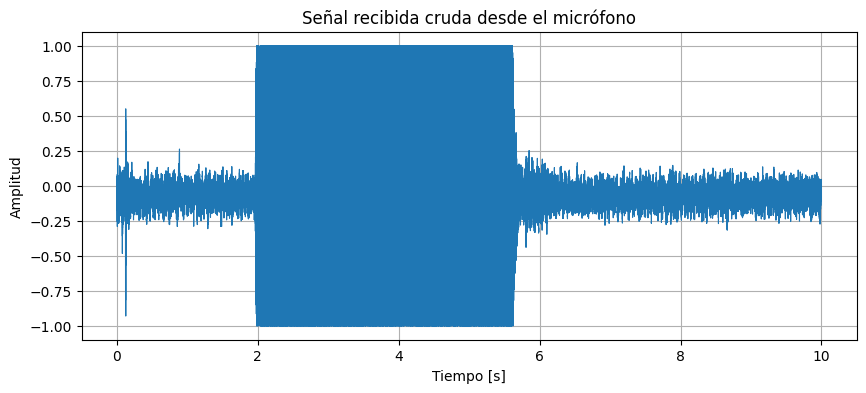

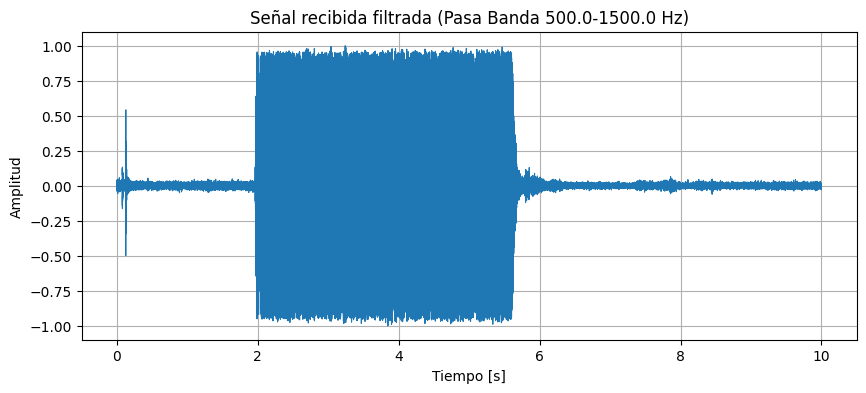

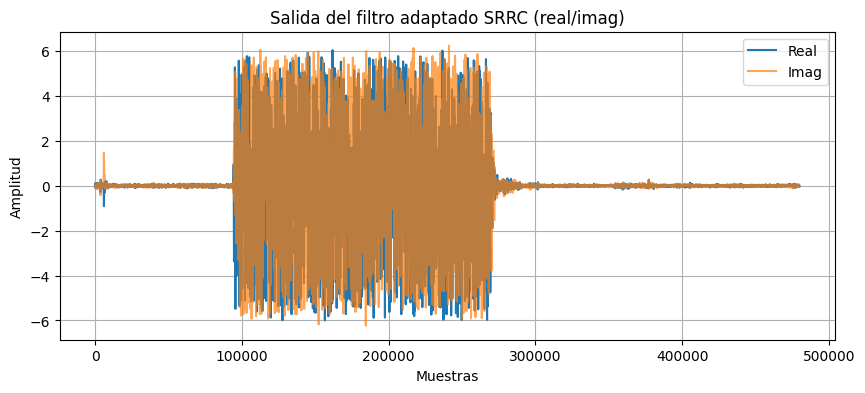

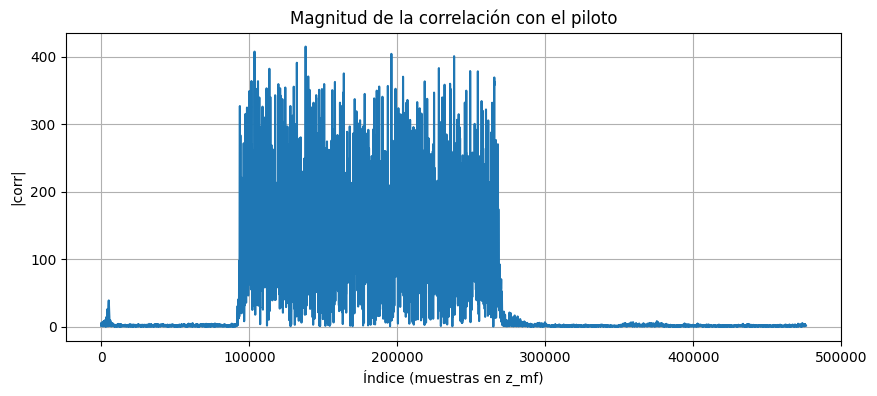

🔎 Pico de correlación en índice: 138069
Fase estimada (rad): -2.5518461764235694


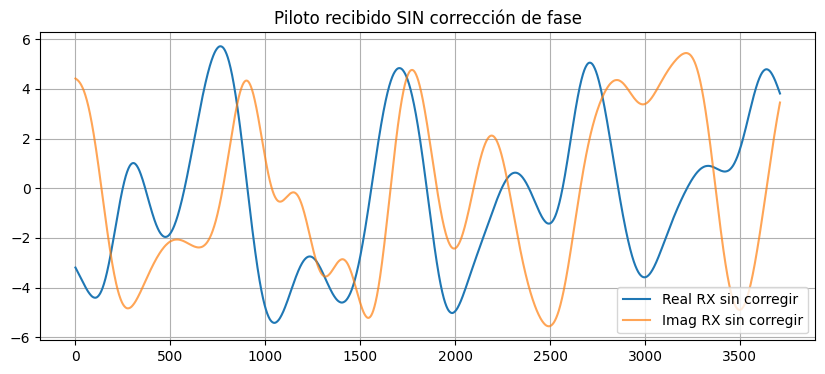

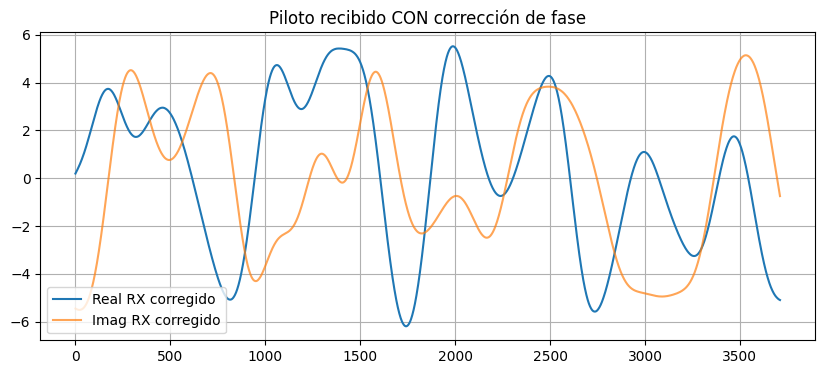

Símbolos extraídos: 3746


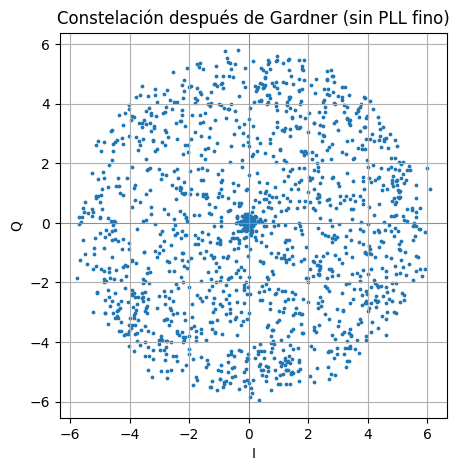

Símbolos de payload: 2638


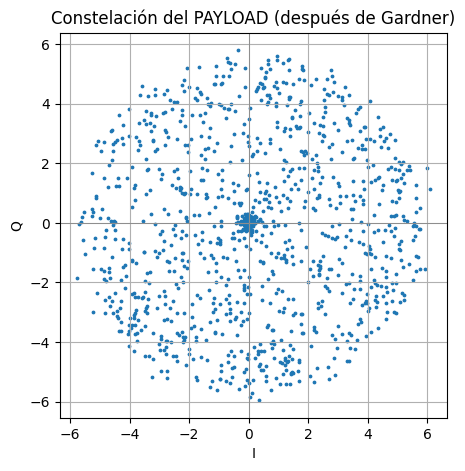

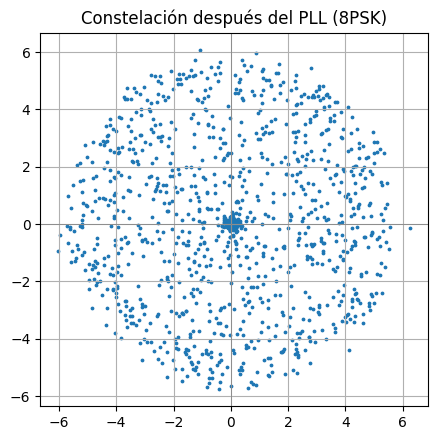

In [21]:
# ============================================
# PIPELINE ACTUAL DEL RECEPTOR (ETAPAS 0–2)
# ============================================
def receive_frontend(fs=48000,
                     max_duration=10.0,
                     fc=1000.0,
                     bw=500.0,
                     bp_order=2,
                     do_plots=True):
    """
    Front-end actual del receptor:
      0) Graba desde el micrófono
      1) Aplica filtro pasa banda alrededor de fc con ancho bw
      2) Normaliza la señal filtrada
      3) (Opcional) Grafica señal cruda y filtrada

    Devuelve:
      t_full      : vector de tiempo
      rx_raw      : señal cruda
      rx_filtered : señal filtrada y normalizada
    """
    # 0) Grabación
    t_full, rx_raw = record_audio(fs=fs, max_duration=max_duration)

    # 1) Filtro pasa banda
    lowcut = fc - bw
    highcut = fc + bw
    rx_bp = bandpass_filter(rx_raw, lowcut, highcut, fs, order=bp_order)

    # 2) Normalización
    rx_filtered = normalize_signal(rx_bp)

    # 3) Gráficas (opcional)
    if do_plots:
        plot_raw_and_filtered(t_full, rx_raw, rx_filtered, lowcut, highcut)

    return t_full, rx_raw, rx_filtered


def receive_baseband(fs=48000,
                     max_duration=10.0,
                     fc=1000.0,
                     bw=500.0,
                     bp_order=2,
                     do_plots=True):
    """
    Front-end + downconversion:
      0) Graba audio
      1) Filtro pasa banda
      2) Normalización
      3) Downconversion a banda base compleja

    Devuelve:
      t_full      : vector de tiempo
      rx_raw      : señal cruda
      rx_filtered : señal filtrada y normalizada (real)
      t_bb        : vector de tiempo (igual que t_full)
      rx_bb       : señal COMPLEJA en banda base
    """
    # Front-end (lo que ya tenías)
    t_full, rx_raw, rx_filtered = receive_frontend(
        fs=fs,
        max_duration=max_duration,
        fc=fc,
        bw=bw,
        bp_order=bp_order,
        do_plots=do_plots
    )

    # Downconversion a banda base
    t_bb, rx_bb = downconvert_to_baseband(rx_filtered, fc, fs)

    return t_full, rx_raw, rx_filtered, t_bb, rx_bb
# ==========================================================
# PIPELINE DEL RECEPTOR HASTA MATCHED FILTER (ETAPAS 0–6)
# ==========================================================
def receive_with_matched_filter(fs=48000,
                                max_duration=10.0,
                                fc=1000.0,
                                bw=500.0,
                                bp_order=2,
                                beta=0.35,
                                span=8,
                                sps=128,
                                do_plots=True):
    """
    Receptor hasta el filtro adaptado SRRC:
      0) Grabación de audio
      1) Filtro pasa banda
      2) Normalización
      3) Downconversion a banda base compleja
      4) Matched filter SRRC

    Devuelve:
      t_full      : vector de tiempo de la señal cruda
      rx_raw      : señal cruda real
      rx_filtered : señal filtrada y normalizada (real)
      t_bb        : vector de tiempo de banda base
      rx_bb       : señal en banda base (compleja)
      z_mf        : salida del matched filter (compleja)
      rrc_taps    : taps del filtro SRRC usado
      delay       : retardo de grupo del filtro
    """
    # Front-end + banda base (lo que ya teníamos)
    t_full, rx_raw, rx_filtered, t_bb, rx_bb = receive_baseband(
        fs=fs,
        max_duration=max_duration,
        fc=fc,
        bw=bw,
        bp_order=bp_order,
        do_plots=do_plots
    )

    # Matched filter SRRC
    z_mf, rrc_taps, delay = apply_matched_filter_srrc(
        rx_bb, beta=beta, span=span, sps=sps
    )

    # Gráfica opcional de la salida del matched filter
    if do_plots:
        plt.figure(figsize=(10,4))
        plt.plot(z_mf.real, label='Real')
        plt.plot(z_mf.imag, label='Imag', alpha=0.7)
        plt.title("Salida del filtro adaptado SRRC (real/imag)")
        plt.xlabel("Muestras")
        plt.ylabel("Amplitud")
        plt.grid(True)
        plt.legend()
        plt.show()

    return t_full, rx_raw, rx_filtered, t_bb, rx_bb, z_mf, rrc_taps, delay

FS = 48000
FC = 1000.0
BW = 500.0
BETA = 0.35
SPAN = 8
SPS = 128
# 1) Receptor hasta matched filter
t_full, rx_raw, rx_filtered, t_bb, rx_bb, z_mf, rrc_taps, delay = \
    receive_with_matched_filter(
        fs=FS,
        max_duration=10,
        fc=FC,
        bw=BW,
        bp_order=2,
        beta=BETA,
        span=SPAN,
        sps=SPS,
        do_plots=True
    )

# 2) Correlación para encontrar inicio del piloto
start_idx, corr_mag = detect_pilot_start(z_mf, rrc_taps, SPS, do_plot=True)

# 3) Extraer piloto y payload
pilot_rx, payload_rx, payload_start, pilot_tx_bb = extract_pilot_and_payload(
    z_mf,
    start_idx,
    rrc_taps,
    SPS,
    fs=FS,
    guard_ms=5.0   # mismo guard_ms que en el TX
)

# 4) Estimar fase inicial
phi_hat = estimate_phase_from_pilot(pilot_rx, pilot_tx_bb)
print("Fase estimada (rad):", phi_hat)

# 5) Corregir fase en toda la señal filtrada
z_corr = apply_phase_correction(z_mf, phi_hat)

plt.figure(figsize=(10,4))
plt.plot(pilot_rx.real, label='Real RX sin corregir')
plt.plot(pilot_rx.imag, label='Imag RX sin corregir', alpha=0.7)
plt.title("Piloto recibido SIN corrección de fase")
plt.grid(True); plt.legend(); plt.show()

pilot_rx_corr = z_corr[start_idx : start_idx + len(pilot_tx_bb)]

plt.figure(figsize=(10,4))
plt.plot(pilot_rx_corr.real, label='Real RX corregido')
plt.plot(pilot_rx_corr.imag, label='Imag RX corregido', alpha=0.7)
plt.title("Piloto recibido CON corrección de fase")
plt.grid(True); plt.legend(); plt.show()

sym_samples, sym_indices = gardner_timing_recovery(
    z_corr,
    sps=SPS,
    mu_init=0.0,
    loop_gain=1e-3,
    n_symbols_max=None  # o pon un número si quieres limitar
)

print("Símbolos extraídos:", len(sym_samples))

plt.figure(figsize=(5,5))
plt.scatter(sym_samples.real, sym_samples.imag, s=3)
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.title("Constelación después de Gardner (sin PLL fino)")
plt.xlabel("I")
plt.ylabel("Q")
plt.grid(True)
plt.gca().set_aspect('equal', 'box')
plt.show()

# sym_indices son los índices en z_corr de cada símbolo tomado
payload_symbol_mask = sym_indices >= payload_start

payload_syms = sym_samples[payload_symbol_mask]
payload_sym_indices = sym_indices[payload_symbol_mask]

print("Símbolos de payload:", len(payload_syms))

plt.figure(figsize=(5,5))
plt.scatter(payload_syms.real, payload_syms.imag, s=3)
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.title("Constelación del PAYLOAD (después de Gardner)")
plt.xlabel("I")
plt.ylabel("Q")
plt.grid(True)
plt.gca().set_aspect('equal', 'box')
plt.show()

pll_syms, pll_phase = pll_costas_8psk(payload_syms, loop_gain=5e-4)
plt.figure(figsize=(5,5))
plt.scatter(pll_syms.real, pll_syms.imag, s=3)
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.title("Constelación después del PLL (8PSK)")
plt.grid(True)
plt.gca().set_aspect('equal', 'box')
plt.show()




<!-- # Graficacion -->